##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum advantage in learning from experiments

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/quantum_advantage_in_learning_from_experiments"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/quantum_advantage_in_learning_from_experiments.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/quantum_advantage_in_learning_from_experiments.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/quantum_advantage_in_learning_from_experiments.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows the experiments of <a target="_blank" href="https://arxiv.org/abs/2112.00778" class="external">Quantum advantage in learning from experiments</a>.

## Setup

In [ ]:
!pip install tensorflow==2.7.0

Now import TensorFlow and the module dependencies:

In [1]:
import tensorflow as tf
import cirq
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt
import numpy as np
from tensorflow_quantum.core.ops.math_ops import simulate_mps
from tensorflow_quantum.python import util

## 1. Creating the circuits

We first define the circuit we are going to use to generate samples. We first define the rotations for the Pauli Measurements.

In [2]:
def inv_z_basis_gate(circuit, pauli, qubit):
    if pauli == "I" or pauli == "Z":
        circuit += cirq.I(qubit)
    elif pauli == "X":
        circuit += cirq.H(qubit)
    elif pauli == "Y":
        # S^dag H to get to computational, H S to go back.        
        circuit += cirq.ZPowGate(exponent=0.5)(qubit)
        circuit += cirq.XPowGate(exponent=0.5)(qubit)
        circuit += cirq.ZPowGate(exponent=1.0)(qubit)
    else:
        raise ValueError("Invalid Pauli.")

The tutorial compares the use of Bell pairs versus not using them (and thus using the previously discovered classical shadows). The point of the paper is that the proposed approach of using Bell pairs is more accurate.

In [3]:
def un_bell_pair_block(qubits):
    return [cirq.CNOT(qubits[0], qubits[1]), cirq.H(qubits[0])]

We then build the circuit. For simplicity, in case we use classical shadows, we only have half the circuit.

In [4]:
def build_circuit(qubit_pairs, pauli, classical_shadows):
    a_qubits = [pair[0] for pair in qubit_pairs]
    b_qubits = [pair[1] for pair in qubit_pairs]
    all_qubits = np.concatenate(qubit_pairs)

    ret_circuit = cirq.Circuit()

    # Add basis turns a and b.
    for q, p in zip(a_qubits, pauli):
        inv_z_basis_gate(ret_circuit, p, q)
    if not classical_shadows:
        for q, p in zip(b_qubits, pauli):
            inv_z_basis_gate(ret_circuit, p, q)

    if classical_shadows:
        # Add measurements.
        for i, qubit in enumerate(a_qubits):
            ret_circuit += cirq.measure(qubit, key=f"q{i}")
    else:  # not classical_shadows
        # Add un-bell pair.
        ret_circuit += [un_bell_pair_block(pair) for pair in qubit_pairs]

        # Add measurements.
        for i, qubit in enumerate(all_qubits):
            ret_circuit += cirq.measure(qubit, key=f"q{i}")

    return ret_circuit



Let us now show some examples of circuits for various Paulis and for both classical shadows and Bell measurements.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


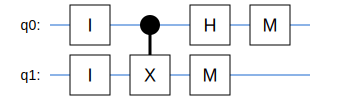

In [5]:
_example_qubits = [(cirq.NamedQubit('q0'), cirq.NamedQubit('q1'))]

SVGCircuit(build_circuit(_example_qubits, 'I', False))

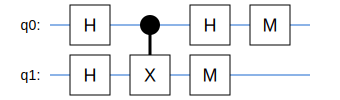

In [6]:
SVGCircuit(build_circuit(_example_qubits, 'X', False))

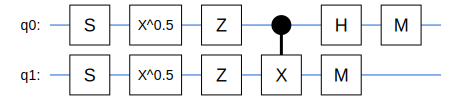

In [7]:
SVGCircuit(build_circuit(_example_qubits, 'Y', False))

In case we do use classical shadows, we only see a single qubit:

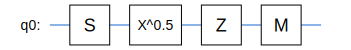

In [8]:
SVGCircuit(build_circuit(_example_qubits, 'Y', True))

We then generate the sweeping parameters, following section A.2.a of the paper.

In [9]:
def create_randomized_sweep(hidden_p, system_pairs, rand_source):
    last_i = 0
    for i, pauli in enumerate(hidden_p):
        if pauli != "I":
            last_i = i

    sign_p = rand_source.choice([1, -1])

    current_sweep = cirq.Circuit()
    for twocopy in [0, 1]:
        parity = sign_p * rand_source.choice([1, -1], p=[0.95, 0.05])
        for i, pauli in enumerate(hidden_p):
            current_flip = rand_source.choice([0, 1])
            if pauli != "I":
                if last_i == i:
                    v = 1 if parity == -1 else 0
                    current_flip = v
                elif current_flip == 1:
                    parity *= -1
            if current_flip == 1:
                current_sweep.append(cirq.X(system_pairs[i][twocopy]))

    return current_sweep

Let us look at an example of a rotation circuit.

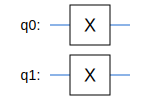

In [10]:
SVGCircuit(create_randomized_sweep('X', _example_qubits, np.random.RandomState(19950610)))

## 2. Create the training data

We first define some constants. Some numbers are chosen to be prime for ease of interpreting the dimenstions. Also, we define the qubits to use. 

In [11]:
rand_source = np.random.RandomState(20160913)
n_paulis = 3
n = 4
n_shots = 11
n_repeats = 13
classical_shadows = False

system_pairs = [(cirq.GridQubit(i, 0), cirq.GridQubit(i, 1)) for i in range(n)]
simulator = cirq.Simulator()

all_results = []

if classical_shadows:
    qubit_order = [f"q{i}" for i in range(n)]
else:  # not classical_shadows
    qubit_order = [f"q{i}" for i in range(2 * n)]

We define a helper function to convert an integer to a Pauli. The reason is we want to guarantee unique Paulis.

In [12]:
def integer_to_pauli(n, pauli_num):
    pauli = ''
    for _ in range(n):
        base4 = pauli_num % 4
        if base4 == 0:
            pauli += 'I'
        elif base4 == 1:
            pauli += 'X'
        elif base4 == 3:
            pauli += 'Y'
        else:
            pauli += 'Z'
        pauli_num = (pauli_num - base4) // 4
    return pauli

We then generate all the Paulis with multiple shots.

In [13]:
paulis = []
for pauli_num in rand_source.choice(range(4**n), n_paulis, replace=False):
    pauli = integer_to_pauli(n, pauli_num)
    paulis.append(pauli)

    base_circuit = build_circuit(system_pairs,
                                 pauli,
                                 classical_shadows=classical_shadows)

    results_for_pauli = []

    # Create randomized flippings. These flippings will contain values of 1,0.
    # which will turn the X gates on or off.
    for _ in range(n_shots):
        rot_circuit = create_randomized_sweep(pauli, system_pairs, rand_source)
        
        results = simulate_mps.mps_1d_sample(
            programs=util.convert_to_tensor(
                [rot_circuit + base_circuit]),
            symbol_names=[], symbol_values=[[]],
            num_samples=[n_repeats],
            bond_dim=16)

        results_for_pauli.append(np.squeeze(results.numpy()))
    all_results.append(results_for_pauli)

all_results = np.array(all_results)

print(all_results.shape)

(3, 11, 13, 8)


## 3. Create the neural network

First, we create the model that encodes the measurements. The first model is a recurrent model (GRU) that encodes along the measurements.

In [14]:
class InnerLayer(tf.keras.Model):

    def __init__(self, n_shots, num_qubits):
        super(InnerLayer, self).__init__(name='inner')
        self.n_shots = n_shots
        self.num_qubits = num_qubits
        self.gru1 = tf.keras.layers.GRU(4,
                                        go_backwards=False,
                                        return_sequences=True)
        self.gru2 = tf.keras.layers.GRU(4,
                                        go_backwards=True,
                                        return_sequences=True)
        self.gru3 = tf.keras.layers.GRU(4,
                                        go_backwards=False,
                                        return_sequences=False)

    def call(self, x):
        x = tf.expand_dims(tf.reshape(x, (-1, self.num_qubits)), -1)
        x = self.gru1(x)
        x = self.gru2(x)
        x = self.gru3(x)
        x = tf.reshape(x, (-1, self.n_shots, 4))
        return x

Then we define an intermediate model that summarizes the output of the recurrent model.

In [15]:
class IntermediateLayer(tf.keras.Model):

    def __init__(self):
        super(IntermediateLayer, self).__init__(name='intermediate')

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=[int(input_shape[2]), 8])

    def call(self, x):
        x = tf.math.reduce_mean(x, axis=1)
        x = tf.matmul(x, self.kernel)
        return x


model = tf.keras.Sequential()
model.add(InnerLayer(n_shots, len(qubit_order)))
model.add(IntermediateLayer())

Then, we define an outer layer whose role is to compare the two outputs and create a softmax output of dimension 2 predicting whether the two Paulis are indentical or not.

In [16]:
class OuterLayer(tf.keras.Model):

    def __init__(self):
        super(OuterLayer, self).__init__(name='')

    def call(self, x):
        x = tf.norm(x[1] - x[0], ord=2, axis=1)
        x = tf.stack([x, tf.ones(tf.shape(x))], axis=1)
        x = tf.nn.softmax(x)
        return x

Finally, we define the conjoined model that compares outputs. It uses two inputs, fed through the individual models, and then we 

In [17]:
input_1 = tf.keras.Input((
    n_shots,
    len(qubit_order),
))
input_2 = tf.keras.Input((
    n_shots,
    len(qubit_order),
))

encoded_1 = model(input_1)
encoded_2 = model(input_2)


predictor = OuterLayer()
prediction = predictor([encoded_1, encoded_2])

conjoined_net = tf.keras.Model(inputs=[input_1, input_2], outputs=prediction)

## 4. Train the model

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

conjoined_net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


def _sample_different(max_val, ref):
    ret = ref
    while ret == ref:
        ret = rand_source.choice(max_val)
    return ret


x1 = []
x2 = []
y = []
for pauli_idx in range(n_paulis):
    # Same Pauli
    for i in range(n_repeats):
        j = _sample_different(n_repeats, i)

        x1.append(all_results[pauli_idx, :, i, :].astype(float))
        x2.append(all_results[pauli_idx, :, j, :].astype(float))
        y.append([1.0, 0.0])

    # Different Pauli
    for i in range(n_repeats):
        other_pauli_idx = _sample_different(n_paulis, pauli_idx)
        j = rand_source.choice(n_repeats)
        x1.append(all_results[pauli_idx, :, i, :].astype(float))
        x2.append(all_results[other_pauli_idx, :, j, :].astype(float))
        y.append([0.0, 1.0])

x1 = np.stack(x1)
x2 = np.stack(x2)
y = np.stack(y)

history = conjoined_net.fit(x=[x1, x2],
                            y=y,
                            epochs=500,
                            batch_size=(2 * n_paulis),
                            verbose=0)

Plot the results.

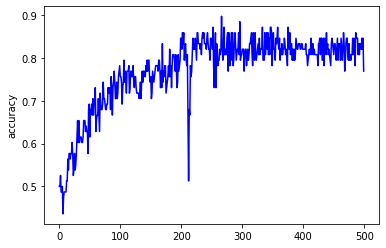

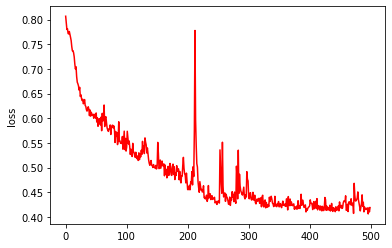

In [19]:
plt.plot(history.history['accuracy'], 'b')
plt.ylabel('accuracy')
plt.show()

plt.plot(history.history['loss'], 'r')
plt.ylabel('loss')
plt.show()